In [1]:
!pwd

/Users/ashish1610dhiman/data_projects/bestbuy/notebooks/ashish


In [2]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

sys.version

sys.path.append("../../")

from src.ad_hmm import sku_predict
from src.utils import *

In [3]:
%load_ext autoreload 
%autoreload 2

### RMSE analysis for HMM

In [4]:
train_test = pd.read_csv("../../data/train_validation_marker.csv")
train_test["SALES_DATE"] = pd.to_datetime(train_test["SALES_DATE"])
print (train_test.shape)

(846632, 15)


In [5]:
#clean train/test
train = train_test[(train_test.validation==False) & (train_test.validation_clean==True)]
validation = train_test[(train_test.validation==True) & (train_test.validation_clean==True)]
train.shape,validation.shape

((797490, 15), (3815, 15))

### y_actual

In [6]:
y_act = validation[["Encoded_SKU_ID","SALES_DATE","DAILY_UNITS"]].rename(columns = {"DAILY_UNITS":"actual"})
y_act.head()

,Encoded_SKU_ID,SALES_DATE,actual
100,96,2022-07-27,2
218,187,2022-07-29,0
420,297,2022-07-29,6
652,372,2022-07-27,1
831,412,2022-07-26,4


### y_pred null

In [11]:
y_pred_null = pd.read_csv("../../data/null_prediction_validation_result_v0.csv").drop(columns = "Unnamed: 0")
y_pred_null["SALES_DATE"] = pd.to_datetime(y_pred_null["SALES_DATE"])
y_pred_null.head()

,Encoded_SKU_ID,SALES_DATE,predicted
0,1,2022-07-25,1
1,1,2022-07-26,1
2,1,2022-07-27,1
3,1,2022-07-28,1
4,1,2022-07-29,1


In [14]:
rmse(y_act,y_pred_null)

6.59603916258372

### y_pred HMM

In [26]:
hmm_output = pd.read_csv("../../data/hmm_result_v0.csv",index_col=0)
hmm_output.head()

,predicted,predicted_30,predicted_45,predicted_60,predicted_max,Encoded_SKU_ID
2022-07-25,1.0,0.0,0.5,1.0,1.0,7
2022-07-26,1.0,0.5,1.0,1.5,0.5,7
2022-07-27,1.0,0.5,0.5,1.5,0.5,7
2022-07-28,0.0,0.5,2.0,1.5,1.0,7
2022-07-29,2.0,0.5,0.0,0.5,1.0,7


In [27]:
hmm_output.index = pd.to_datetime(hmm_output.index)

In [25]:
y_pred_hmm.dtypes

Encoded_SKU_ID      int64
SALES_DATE         object
predicted         float64
dtype: object

In [29]:
SKUs_hmm = hmm_output["Encoded_SKU_ID"].unique()
y_pred_null_subset = y_pred_null[y_pred_null.Encoded_SKU_ID.isin(SKUs_hmm)]

In [30]:
rmse(y_act,y_pred_null_subset)

1.2758050679584916

In [31]:
for col in hmm_output.columns:
    if "pred" in col:
        y_pred_hmm = hmm_output.reset_index(names = "SALES_DATE")[["Encoded_SKU_ID","SALES_DATE",col\
                                                                  ]].rename(columns={col:"predicted"})
        print (f"For {col}, rmse(hmm) = {rmse(y_act,y_pred_hmm):.4f}")

For predicted, rmse(hmm) = 1.3527
For predicted_30, rmse(hmm) = 1.3724
For predicted_45, rmse(hmm) = 1.2986
For predicted_60, rmse(hmm) = 1.3315
For predicted_max, rmse(hmm) = 1.2358


In [32]:
(1.2758050679584916 - 1.2358)*100/1.2758050679584916

3.1356724442634945

### RMSE SKU level

In [35]:
rmse_sku_null = rmse_sku(y_act,y_pred_null)
rmse_sku_hmm = rmse_sku(y_act,y_pred_hmm)

In [131]:
rmse_sku_hmm.to_excel("../../results/sku_level_hmm_rmse.xlsx")

In [39]:
rmse_joined = rmse_sku_null.merge(rmse_sku_hmm, left_index = True, right_index = True,\
                                suffixes = ("_null","_hmm"))

In [40]:
rmse_joined.head()

,rmse_du_null,mean_du_null,pct_rmse_null,rmse_du_hmm,mean_du_hmm,pct_rmse_hmm
Encoded_SKU_ID,,,,,,
306,4.105745,1.000000,4.105745,2.052873,1.000000,2.052873
380,3.316625,0.714286,4.643275,0.866025,0.714286,1.212436
73,3.139609,1.571429,1.997933,3.070598,1.571429,1.954017
526,2.777460,3.000000,0.925820,3.223795,3.000000,1.074598
57,2.751623,0.285714,9.630680,0.422577,0.285714,1.479020


In [43]:
((rmse_joined["mean_du_null"] == rmse_joined["mean_du_hmm"])==False).sum()

0

In [44]:
(rmse_joined["rmse_du_hmm"] < rmse_joined["rmse_du_null"]).mean()

0.44375

In [45]:
(rmse_joined["rmse_du_hmm"] <= rmse_joined["rmse_du_null"]).mean()

0.53125

In [46]:
rmse_joined["delta_rmse"] = rmse_joined["rmse_du_null"] - rmse_joined["rmse_du_hmm"]
rmse_joined.sort_values(by="delta_rmse", ascending = False)

,rmse_du_null,mean_du_null,pct_rmse_null,rmse_du_hmm,mean_du_hmm,pct_rmse_hmm,delta_rmse
Encoded_SKU_ID,,,,,,,
380,3.316625,0.714286,4.643275,0.866025,0.714286,1.212436,2.450599
57,2.751623,0.285714,9.630680,0.422577,0.285714,1.479020,2.329046
306,4.105745,1.000000,4.105745,2.052873,1.000000,2.052873,2.052873
245,2.329929,0.714286,3.261901,0.534522,0.714286,0.748331,1.795407
397,2.390457,0.714286,3.346640,1.000000,0.714286,1.400000,1.390457
...,...,...,...,...,...,...,...
519,0.654654,0.428571,1.527525,2.000000,0.428571,4.666667,-1.345346
27,0.534522,0.285714,1.870829,1.927248,0.285714,6.745369,-1.392726
465,1.511858,2.857143,0.529150,3.023716,2.857143,1.058301,-1.511858


In [48]:
rmse_joined.loc[rmse_joined["delta_rmse"]>0.0]["mean_du_null"].mean()

0.7686116700201207

In [49]:
rmse_joined.loc[rmse_joined["delta_rmse"]==0.0]["mean_du_null"].mean()

0.5

In [50]:
rmse_joined.loc[rmse_joined["delta_rmse"]<0.0]["mean_du_null"].mean()

0.8400000000000001

In [51]:
rmse_joined.sort_values(by="delta_rmse", ascending = True)

,rmse_du_null,mean_du_null,pct_rmse_null,rmse_du_hmm,mean_du_hmm,pct_rmse_hmm,delta_rmse
Encoded_SKU_ID,,,,,,,
447,1.463850,2.000000,0.731925,3.712912,2.000000,1.856456,-2.249062
30,0.845154,1.142857,0.739510,2.679286,1.142857,2.344375,-1.834131
465,1.511858,2.857143,0.529150,3.023716,2.857143,1.058301,-1.511858
27,0.534522,0.285714,1.870829,1.927248,0.285714,6.745369,-1.392726
519,0.654654,0.428571,1.527525,2.000000,0.428571,4.666667,-1.345346
...,...,...,...,...,...,...,...
397,2.390457,0.714286,3.346640,1.000000,0.714286,1.400000,1.390457
245,2.329929,0.714286,3.261901,0.534522,0.714286,0.748331,1.795407
306,4.105745,1.000000,4.105745,2.052873,1.000000,2.052873,2.052873


### Plot some preds

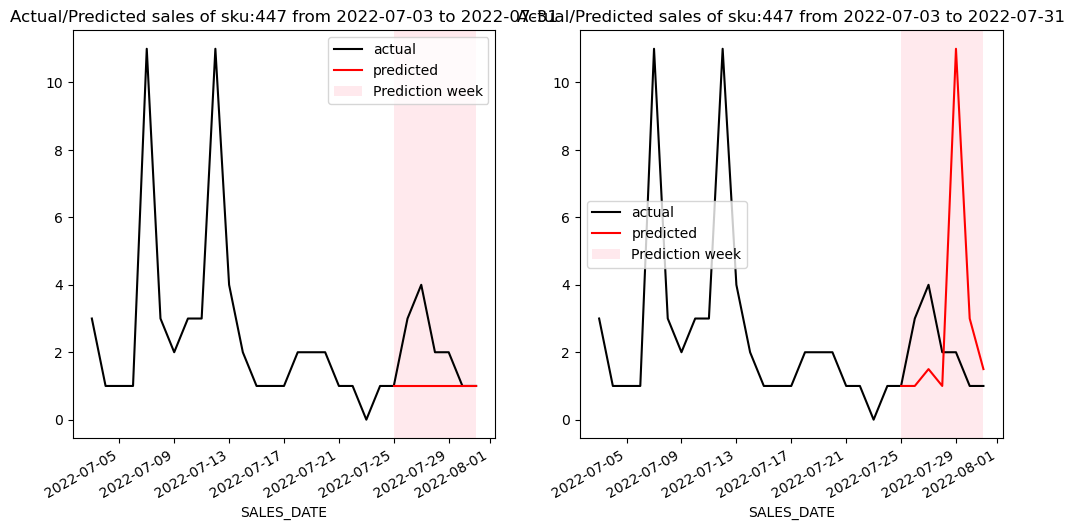

In [82]:
sku_id = 447
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm, sku_id, ax1 = ax[1])

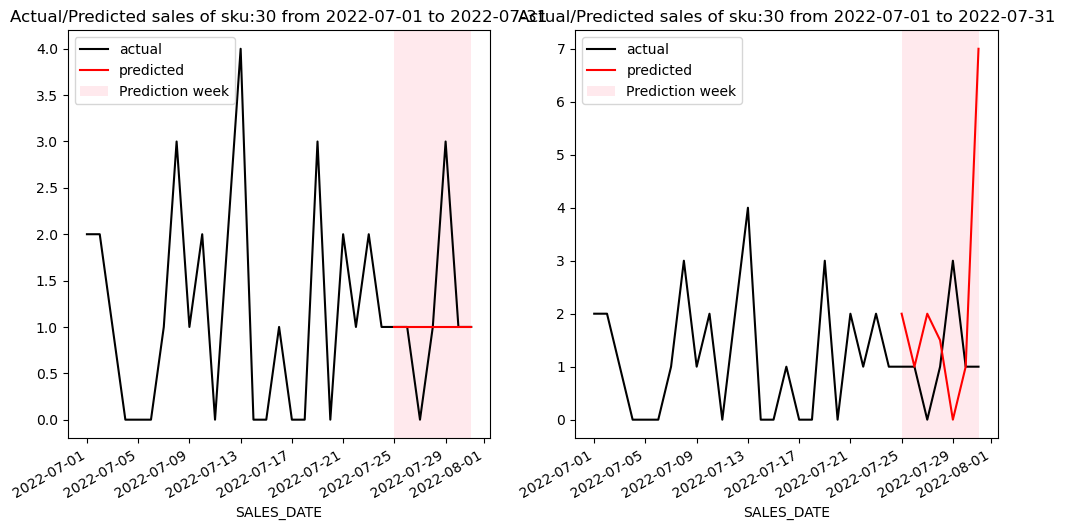

In [83]:
sku_id = 30
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm, sku_id, ax1 = ax[1])

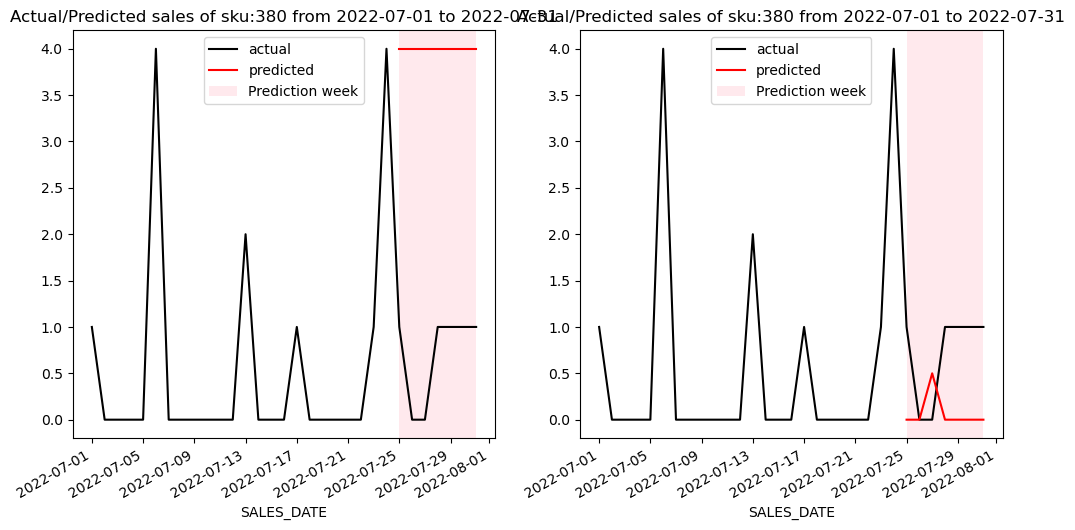

In [84]:
sku_id = 380
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm, sku_id, ax1 = ax[1])

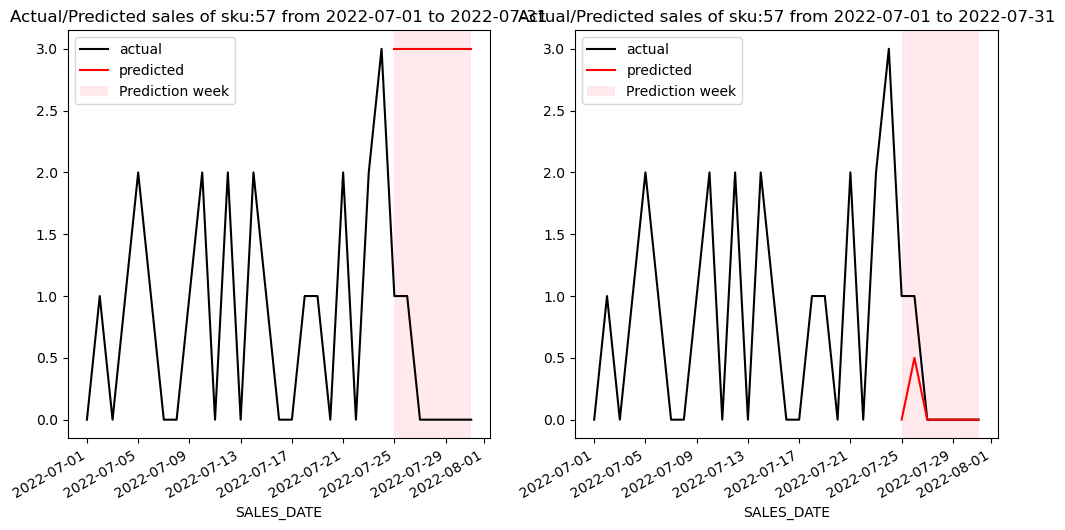

In [85]:
sku_id = 57
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_pred_sku(train,y_act, y_pred_null, sku_id, ax1 = ax[0])
plot_pred_sku(train,y_act, y_pred_hmm, sku_id, ax1 = ax[1])

### Pick best prediction column for each SKU

In [89]:
rmse_sku_hmm_dates = pd.DataFrame()
for i,col in enumerate(hmm_output.columns):
    if "pred" in col:
        y_pred_hmm = hmm_output.reset_index(names = "SALES_DATE")[["Encoded_SKU_ID","SALES_DATE",col\
                                                                  ]].rename(columns={col:"predicted"})
        rmse_sku_hmm_i = rmse_sku(y_act,y_pred_hmm)
        if i ==0:
            rmse_sku_hmm_dates = rmse_sku_hmm_i
        else:
            rmse_sku_hmm_dates = rmse_sku_hmm_dates.merge(rmse_sku_hmm, left_index = True, right_index = True,\
                                suffixes = ("",f"_{col.split('_')[-1]}"))

In [132]:
rmse_sku_hmm_dates[[col for col in rmse_sku_hmm_dates.columns if "rmse_du" in col\
                                                    ]]

,rmse_du,rmse_du_30,rmse_du_45,rmse_du_60,rmse_du_max
Encoded_SKU_ID,,,,,
447,5.147815,3.712912,3.712912,3.712912,3.712912
73,3.070598,3.070598,3.070598,3.070598,3.070598
53,2.853569,2.070197,2.070197,2.070197,2.070197
465,2.738613,3.023716,3.023716,3.023716,3.023716
543,2.535463,1.133893,1.133893,1.133893,1.133893
...,...,...,...,...,...
51,0.422577,0.866025,0.866025,0.866025,0.866025
389,0.422577,0.500000,0.500000,0.500000,0.500000
308,0.377964,0.654654,0.654654,0.654654,0.654654


In [106]:
rmse_sku_hmm_dates["min_rmse"] = rmse_sku_hmm_dates[[col for col in rmse_sku_hmm_dates.columns if "rmse_du" in col\
                                                    ]].min()

rmse_sku_hmm_dates["argmin_period"] = np.argmin(rmse_sku_hmm_dates[[col for col in rmse_sku_hmm_dates.columns if "rmse_du" in col\
                                                    ]].values,axis=1)

In [107]:
col_list = np.array([col for col in rmse_sku_hmm_dates.columns if "rmse_du" in col])
col_list

array(['rmse_du', 'rmse_du_30', 'rmse_du_45', 'rmse_du_60', 'rmse_du_max'],
      dtype='<U11')

In [108]:
rmse_sku_hmm_dates["min_period"] = rmse_sku_hmm_dates["argmin_period"].apply(lambda x: col_list[x])

#### Get prediction basis best rmse

In [111]:
rmse_sku_hmm_dates.head()

,rmse_du,mean_du,pct_rmse,rmse_du_30,mean_du_30,pct_rmse_30,rmse_du_45,mean_du_45,pct_rmse_45,rmse_du_60,mean_du_60,pct_rmse_60,rmse_du_max,mean_du_max,pct_rmse_max,min_rmse,argmin_period,min_period
Encoded_SKU_ID,,,,,,,,,,,,,,,,,,
447,5.147815,2.000000,2.573908,3.712912,2.000000,1.856456,3.712912,2.000000,1.856456,3.712912,2.000000,1.856456,3.712912,2.000000,1.856456,NaN,1,rmse_du_30
73,3.070598,1.571429,1.954017,3.070598,1.571429,1.954017,3.070598,1.571429,1.954017,3.070598,1.571429,1.954017,3.070598,1.571429,1.954017,NaN,0,rmse_du
53,2.853569,2.285714,1.248437,2.070197,2.285714,0.905711,2.070197,2.285714,0.905711,2.070197,2.285714,0.905711,2.070197,2.285714,0.905711,NaN,1,rmse_du_30
465,2.738613,2.857143,0.958514,3.023716,2.857143,1.058301,3.023716,2.857143,1.058301,3.023716,2.857143,1.058301,3.023716,2.857143,1.058301,NaN,0,rmse_du
543,2.535463,0.571429,4.437060,1.133893,0.571429,1.984313,1.133893,0.571429,1.984313,1.133893,0.571429,1.984313,1.133893,0.571429,1.984313,NaN,1,rmse_du_30


In [110]:
period_col_map= {
    "rmse_du":"predicted", "rmse_du_30":"predicted_30", "rmse_du_45":"predicted_45",\
    "rmse_du_60":"predicted_60", "rmse_du_max":"predicted_max"
}

In [124]:
hmm_output.loc[mask_sku].reset_index(names = "SALES_DATE")[["Encoded_SKU_ID","SALES_DATE",best_col\
                                                                  ]]

,Encoded_SKU_ID,SALES_DATE,predicted
0,73,2022-07-25,1.0
1,73,2022-07-26,1.0
2,73,2022-07-27,0.0
3,73,2022-07-28,1.0
4,73,2022-07-29,0.0
5,73,2022-07-30,0.0
6,73,2022-07-31,0.0


In [125]:
y_pred_hmm_best = pd.DataFrame()
cnt = 0
for sku_id,best_period in zip(rmse_sku_hmm_dates.index,rmse_sku_hmm_dates["min_period"]):
    best_col = period_col_map[best_period]
    mask_sku = hmm_output.Encoded_SKU_ID==sku_id
    y_pred_hmm_sku = hmm_output.loc[mask_sku].reset_index(names = "SALES_DATE")[["Encoded_SKU_ID","SALES_DATE",best_col\
                                                                  ]].rename(columns={best_col:"predicted"})
    y_pred_hmm_best = pd.concat([y_pred_hmm_best,y_pred_hmm_sku])

In [126]:
y_pred_hmm_best.shape,y_pred_hmm.shape

((1120, 3), (1120, 3))

In [129]:
y_pred_hmm_max = hmm_output.reset_index(names = "SALES_DATE")[["Encoded_SKU_ID","SALES_DATE","predicted_max"\
                                                                  ]].rename(columns={"predicted_max":"predicted"})

In [130]:
rmse(y_act,y_pred_null_subset),rmse(y_act,y_pred_hmm_max),rmse(y_act,y_pred_hmm_best)

(1.2758050679584916, 1.2358123412788622, 1.254545307500462)